## Load package and seth path

In [19]:
%matplotlib inline

import os,sys
import pandas as pd
import numpy as np
import geopandas as gpd
import rasterio
#!pip install geopy
#!pip install boltons
from pathlib import Path
from geofeather.pygeos import to_geofeather, from_geofeather
from tqdm import tqdm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from rasterio.plot import show
from IPython.display import display #when printing geodataframes, put it in columns -> use display(df)
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator, LinearLocator, MaxNLocator)
import pygeos
from pgpkg import Geopackage
import matplotlib.pyplot as plt
import copy

sys.path.append("C:\Projects\gmhcira\scripts")
#import fetch
#import cisi
#import extract
#import cisi_exposure
import functions
plt.rcParams['figure.figsize'] = [20, 20]

from osgeo import gdal
gdal.SetConfigOption("OSM_CONFIG_FILE", os.path.join("..","osmconf.ini"))



### Set pathways

In [20]:
base_path = os.path.abspath(r'C:\Users\snn490\surfdrive\PhD documents\RECEIPT project\Deliverables\Deliverable 2021') #this path contains all data that's needed as input and will contain directories to export outputs

# Set path to inputdata
damage_data_path = os.path.abspath(os.path.join(r'\\labsdfs.labs.vu.nl\labsdfs\BETA-IVM-BAZIS\data_catalogue\open_street_map\receipt_storylines\damage_data')) #path to map with damage data 

# path to save outputs - automatically made, not necessary to change output pathways
output_path = os.path.abspath(os.path.join(base_path, 'figures')) #save figures

# path to our python scripts
sys.path.append(os.path.join('..','scripts'))

#Create folders for outputs (GPKGs and pngs)
Path(output_path).mkdir(parents=True, exist_ok=True)

## Set variables

In [21]:
assets = {"energy": {"power": ["line", "minor_line","cable","plant","substation",
                                        "power_tower","power_pole"]}, 
                "transportation": {"roads":  ["motorway","trunk","primary", "secondary", "tertiary","other"], 
                                    "airports": ["airports", "runway", "terminal"],
                                    "railways": ["railway"]},
                "water": {"water_supply": ["water_tower", "water_well", "reservoir_covered",
                                            "water_works"]},
                "waste": {"waste_solid": ["waste_transfer_station"],
                        "waste_water": ["wastewater_treatment_plant"]},
                "telecommunication": {"telecom": ["communication_tower", "mast"]},
                "healthcare": {"health": ["clinic", "doctors", "hospital", "dentist", "pharmacy", 
                            "physiotherapist", "alternative", "laboratory", "optometrist", "rehabilitation", 
                            "blood_donation", "birthing_center"]},
                "education": {"education_facilities": ["college", "kindergarten", "library", "school", "university"]}
                }

# create variables
system_lst = [system for system in assets] #make list with systems
#subsystem_lst = [subsystem for system in assets for subsystem in assets[system]] #make list with subsystems

In [22]:
def organize_columns_old(subset_df):

    subset_df = subset_df.sort_values(by='damage', ascending=False)
    x = np.char.array(subset_df.index.tolist())
    y = np.array(subset_df['damage'].tolist())
    relative = 100.*y/y.sum()
    
    return x,y,relative

def organize_columns(subset_df):

    subset_df = subset_df.sort_values(by='damage', ascending=False)
    x = np.char.array(subset_df.index.tolist())
    y = np.array(subset_df['damage'].tolist())
    if subset_df['damage'].sum() == 0:
        relative = np.array([0.0] * len(damage_dict['water']))
    else: 
        relative = 100.*y/y.sum()
    
    return x,y,relative

def get_list_per_system(assets):
    infra_per_system_dict = {}
    for system in assets:
        subsystem_count = 0
        for subsystem in assets[system]:
            subsystem_count += 1
            if subsystem_count == 1:
                infra_per_system_dict[system] = assets[system][subsystem] #add key-value pair
            elif subsystem_count > 1:
                infra_per_system_dict[system] = infra_per_system_dict[system] + assets[system][subsystem] 
                
    return infra_per_system_dict

## Create bar plots per system

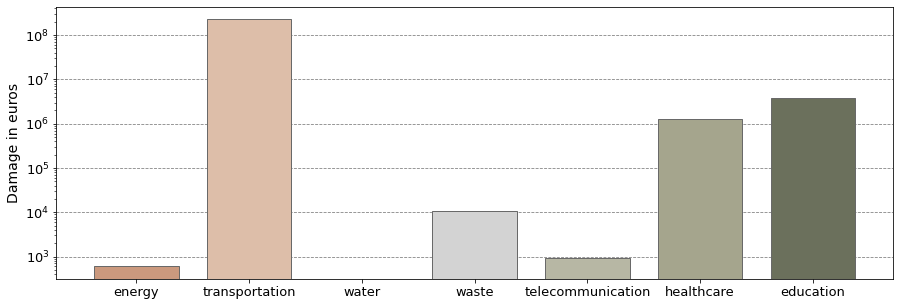

Xynthia 230987639.20689562


In [181]:
#without correction for airports, based on csv's

storms_lst = ['Xynthia']#, 'Xaver', 'EmiliaRomagna']
for storm in storms_lst:
    #import data
    damage_df = pd.read_csv(os.path.join(damage_data_path, 'total_damage_{}.csv'.format(storm)))#, sheet_name="Sheet1")
    #summary_df = summary_df.set_index('ISO_3digit')

    #organize data
    lst_zeros = [0.0] * len(system_lst)
    damage_system_df = pd.DataFrame({'ci_system':system_lst})
    damage_system_df.insert(1, 'damage', lst_zeros)
    damage_system_df = damage_system_df.set_index('ci_system')    

    for system in system_lst:
        for subsystem in assets[system]:
            asset_lst = assets[system][subsystem]
            #print(asset_lst)
            for asset in asset_lst:
                if True in (damage_df['asset']==asset).unique():
                    sub_df = damage_df[damage_df['asset']==asset]
                    #print('True is {}:{}'.format(asset, sub_df['damage'].sum()))
                    damage_system_df.loc[system, 'damage'] += sub_df['damage'].sum()
                    #print(damage_system_df.loc[system, 'damage'] )
                #else:
                    #print('Not true: {}'.format(asset))

    #make figure
    fig, ax = plt.subplots(figsize=(15, 5))
    colors_id = ['#CB997E', '#ddbea9', '#FFE8D6', 'lightgray', '#B7B7A4','#A5A58D', '#6B705C'] #transportation, energy, education, healthcare, water, telecommunication, waste #B9E0A5
    ax.bar(damage_system_df.index.tolist(), damage_system_df['damage'].tolist(), color=colors_id, width=0.75, edgecolor='dimgrey')
    ax.set_ylabel('Damage in euros', fontsize=14)
    ax.set_axisbelow(True)
    ax.grid(axis='y', color='gray', linestyle='dashed')
    #ax.set_ylim([1,100000000000]) #range
    #ax.tick_params(axis='y', which='minor')
    #ax.yaxis.set_major_formatter(ScalarFormatter()) #from matplotlib.ticker import ScalarFormatter
    #ax.minorticks_off()
    #ax.set_yticks(np.arange(1, 100000000000, step=100))

    ax.set_yscale('log')
    ax.tick_params(axis='both', which='major', labelsize=13)
    #ax.tick_params(axis='both', which='minor', labelsize=13)
    plt.show()
    
    print(storm, damage_system_df.damage.sum()) #use damage_df['damage'].sum() for all assets.. We won't use damages for landfills in project

    #fig.savefig(os.path.join(output_path, 'Fig_bar_{}.png'.format(storm)), bbox_inches='tight', dpi=1000)
    #damage_df_xcl = damage_df.copy()
    #damage_system_df_xcl = damage_system_df.copy()
    

In [182]:
damage_systemf

,damage
ci_system,
energy,6.004025e+02
transportation,2.258383e+08
water,0.000000e+00
waste,1.090448e+04
telecommunication,9.303478e+02
healthcare,1.260017e+06
education,3.876859e+06


In [12]:
assets = {"energy": {"power": ["line", "minor_line","cable","plant","substation",
                                        "power_tower","power_pole"]}, 
                "transportation": {"roads":  ["motorway","trunk","primary", "secondary", "tertiary","other"], 
                                    "airports": ["airports", "runway", "terminal"],
                                    "railways": ["railway"]},
                "water": {"water_supply": ["water_tower", "water_well", "reservoir_covered",
                                            "water_works"]},
                "waste": {"waste_solid": ["waste_transfer_station"],
                        "waste_water": ["wastewater_treatment_plant"]},
                "telecommunication": {"telecom": ["communication_tower", "mast"]},
                "healthcare": {"health": ["clinic", "doctors", "hospital", "dentist", "pharmacy", 
                            "physiotherapist", "alternative", "laboratory", "optometrist", "rehabilitation", 
                            "blood_donation", "birthing_center"]},
                "education": {"education_facilities": ["college", "kindergarten", "library", "school", "university"]}
                }

# create variables
system_lst = [system for system in assets] #make list with systems
#subsystem_lst = [subsystem for system in assets for subsystem in assets[system]] #make list with subsystems

#storm_dict = {'Xynthia': 'FRA'}#, 'Xaver': 'DEU', 'EmiliaRomagna': 'ITA'} 
storm_dict = {'Xaver': 'DEU'}
#storm_dict = {'EmiliaRomagna': 'ITA'} 

Xynthia


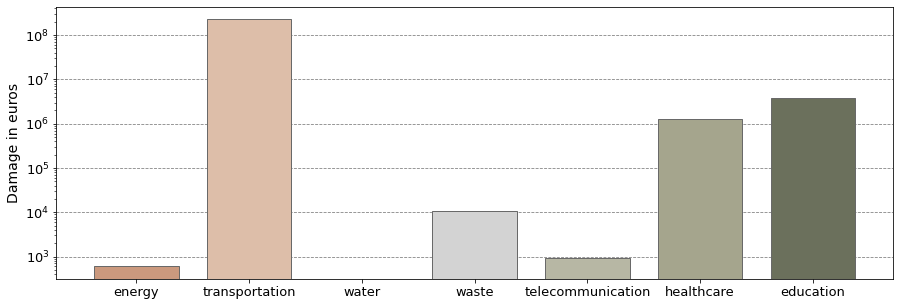

Xynthia 230987639.20689562


In [51]:
#without correction for airports, based on shapefiles
damage_dict = {}
infra_per_system_dict = get_list_per_system(assets) #get list per system
datatypes_dict = {'power':['lines','poly','point'],'airports':['lines','poly']}  

for storm in storm_dict:
    print(storm)
    
    #organize damage data per asset per system 
    for system in system_lst:
        lst_zeros = [0.0] * len(infra_per_system_dict[system])
        subset_df = pd.DataFrame({'infrastructure_type':infra_per_system_dict[system]})
        subset_df.insert(1, 'damage', lst_zeros)
        subset_df = subset_df.set_index('infrastructure_type')

        for sub_system in assets[system]:
            if sub_system == 'power':
                for datatype in datatypes_dict['power']:
                    temp_df = gpd.read_file(os.path.join(damage_data_path, '{}_{}_{}.shp'.format(storm_dict[storm], sub_system, datatype)))
                    temp_df = temp_df[['asset','damage']]
                    for asset in infra_per_system_dict[system]:
                        if True in (temp_df['asset']==asset).unique():
                            subset_df.loc[asset, 'damage'] += (temp_df[temp_df['asset']==asset])['damage'].sum()
                    damage_dict['{}'.format(system)] = subset_df  
            elif sub_system == 'airports':
                for datatype in datatypes_dict['airports']:
                    temp_df = gpd.read_file(os.path.join(damage_data_path, '{}_{}_{}.shp'.format(storm_dict[storm], sub_system, datatype)))
                    temp_df = temp_df[['asset','damage']]
                    for asset in infra_per_system_dict[system]:
                        if True in (temp_df['asset']==asset).unique():
                            subset_df.loc[asset, 'damage'] += (temp_df[temp_df['asset']==asset])['damage'].sum()
                    damage_dict['{}'.format(system)] = subset_df  
            else:
                if os.path.isfile(os.path.join(damage_data_path, '{}_{}.shp'.format(storm_dict[storm], sub_system))):
                    temp_df = gpd.read_file(os.path.join(damage_data_path, '{}_{}.shp'.format(storm_dict[storm], sub_system)))
                    temp_df = temp_df[['asset','damage']]
                    for asset in infra_per_system_dict[system]:
                        if True in (temp_df['asset']==asset).unique():
                            subset_df.loc[asset, 'damage'] += (temp_df[temp_df['asset']==asset])['damage'].sum()
                    damage_dict['{}'.format(system)] = subset_df
                else:
                    damage_dict['{}'.format(system)] = subset_df
                    
    #calculate total damage per system
    #organize data
    lst_zeros = [0.0] * len(system_lst)
    damage_system_df = pd.DataFrame({'ci_system':system_lst})
    damage_system_df.insert(1, 'damage', lst_zeros)
    damage_system_df = damage_system_df.set_index('ci_system')  

    for system in system_lst:
        for subsystem in assets[system]:
            asset_lst = assets[system][subsystem]
            for asset in asset_lst:
                if asset in damage_dict[system].index.values:
                    damage_system_df.loc[system, 'damage'] += damage_dict[system].loc[asset].damage

    #make figure
    fig, ax = plt.subplots(figsize=(15, 5))
    colors_id = ['#CB997E', '#ddbea9', '#FFE8D6', 'lightgray', '#B7B7A4','#A5A58D', '#6B705C'] #transportation, energy, education, healthcare, water, telecommunication, waste #B9E0A5
    ax.bar(damage_system_df.index.tolist(), damage_system_df['damage'].tolist(), color=colors_id, width=0.75, edgecolor='dimgrey')
    ax.set_ylabel('Damage in euros', fontsize=14)
    ax.set_axisbelow(True)
    ax.grid(axis='y', color='gray', linestyle='dashed')
    #ax.set_ylim([1,100000000000]) #range
    #ax.tick_params(axis='y', which='minor')
    #ax.yaxis.set_major_formatter(ScalarFormatter()) #from matplotlib.ticker import ScalarFormatter
    #ax.minorticks_off()
    #ax.set_yticks(np.arange(1, 100000000000, step=100))

    ax.set_yscale('log')
    ax.tick_params(axis='both', which='major', labelsize=13)
    #ax.tick_params(axis='both', which='minor', labelsize=13)
    plt.show()
    


    print(storm, damage_system_df.damage.sum()) #damage_df['damage'].sum(), damage_df[damage_df['asset']=='airports']['damage'].sum())  #display total damage to CI (excluding correction airports)


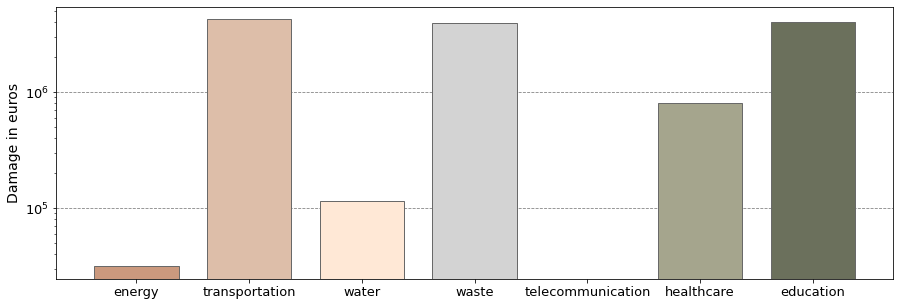

Xaver 13110907.262204487


In [30]:
#with correction for airports, based on csv

for storm in storm_dict:
    #import data
    damage_df = pd.read_csv(os.path.join(damage_data_path, 'total_damage_{}.csv'.format(storm)))#, sheet_name="Sheet1")
    #summary_df = summary_df.set_index('ISO_3digit')

    #organize data
    lst_zeros = [0.0] * len(system_lst)
    damage_system_df = pd.DataFrame({'ci_system':system_lst})
    damage_system_df.insert(1, 'damage', lst_zeros)
    damage_system_df = damage_system_df.set_index('ci_system')    

    for system in system_lst:
        for subsystem in assets[system]:
            asset_lst = assets[system][subsystem]
            for asset in asset_lst:
                if True in (damage_df['asset']==asset).unique():
                    if asset != 'airports':
                        sub_df = damage_df[damage_df['asset']==asset]
                        sub_df['damage'].sum()
                        damage_system_df.loc[system, 'damage'] += sub_df['damage'].sum()

    #make figure
    fig, ax = plt.subplots(figsize=(15, 5))
    colors_id = ['#CB997E', '#ddbea9', '#FFE8D6', 'lightgray', '#B7B7A4','#A5A58D', '#6B705C'] #transportation, energy, education, healthcare, water, telecommunication, waste #B9E0A5
    ax.bar(damage_system_df.index.tolist(), damage_system_df['damage'].tolist(), color=colors_id, width=0.75, edgecolor='dimgrey')
    ax.set_ylabel('Damage in euros', fontsize=14)
    ax.set_axisbelow(True)
    ax.grid(axis='y', color='gray', linestyle='dashed')
    #ax.set_ylim([1,100000000000]) #range
    #ax.tick_params(axis='y', which='minor')
    #ax.yaxis.set_major_formatter(ScalarFormatter()) #from matplotlib.ticker import ScalarFormatter
    #ax.minorticks_off()
    #ax.set_yticks(np.arange(1, 100000000000, step=100))

    ax.set_yscale('log')
    ax.tick_params(axis='both', which='major', labelsize=13)
    #ax.tick_params(axis='both', which='minor', labelsize=13)
    plt.show()
    
    #print(storm, damage_df['damage'].sum(), damage_df[damage_df['asset']=='airports']['damage'].sum())  #display total damage to CI (including correction airports), damage to airports
    print(storm, damage_system_df.damage.sum()) #use damage_df['damage'].sum() for all assets.. We won't use damages for landfills and airports in project
    
    #fig.savefig(os.path.join(output_path, 'Fig_bar_{}.png'.format(storm)), bbox_inches='tight', dpi=1000)

Xynthia


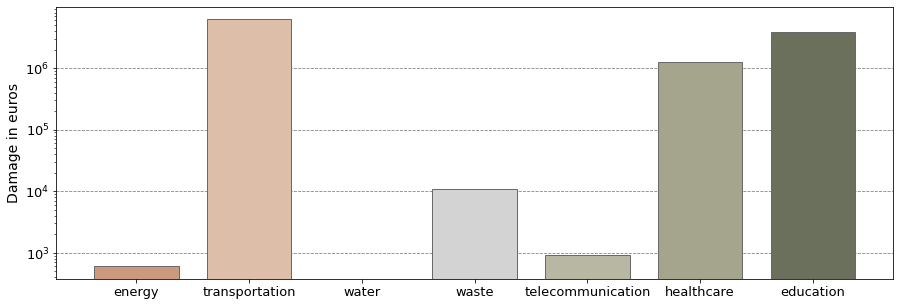

Xynthia 11340673.302821517


In [66]:
#with correction for airports, based on shapefiles
damage_dict = {}
infra_per_system_dict = get_list_per_system(assets) #get list per system
datatypes_dict = {'power':['lines','poly','point'],'airports':['lines','poly']} 

for storm in storm_dict:
    print(storm)
    
    #organize damage data per asset per system 
    for system in system_lst:
        lst_zeros = [0.0] * len(infra_per_system_dict[system])
        subset_df = pd.DataFrame({'infrastructure_type':infra_per_system_dict[system]})
        subset_df.insert(1, 'damage', lst_zeros)
        subset_df = subset_df.set_index('infrastructure_type')

        for sub_system in assets[system]:
            if sub_system == 'power':
                for datatype in datatypes_dict['power']:
                    temp_df = gpd.read_file(os.path.join(damage_data_path, '{}_{}_{}.shp'.format(storm_dict[storm], sub_system, datatype)))
                    temp_df = temp_df[['asset','damage']]
                    for asset in infra_per_system_dict[system]:
                        if True in (temp_df['asset']==asset).unique():
                            subset_df.loc[asset, 'damage'] += (temp_df[temp_df['asset']==asset])['damage'].sum()
                    damage_dict['{}'.format(system)] = subset_df  
            elif sub_system == 'airports':
                for datatype in datatypes_dict['airports']:
                    temp_df = gpd.read_file(os.path.join(damage_data_path, '{}_{}_{}.shp'.format(storm_dict[storm], sub_system, datatype)))
                    temp_df = temp_df[['asset','damage']]
                    for asset in infra_per_system_dict[system]:
                        if True in (temp_df['asset']==asset).unique():
                            subset_df.loc[asset, 'damage'] += (temp_df[temp_df['asset']==asset])['damage'].sum()
                    damage_dict['{}'.format(system)] = subset_df  
            else:
                if os.path.isfile(os.path.join(damage_data_path, '{}_{}.shp'.format(storm_dict[storm], sub_system))):
                    temp_df = gpd.read_file(os.path.join(damage_data_path, '{}_{}.shp'.format(storm_dict[storm], sub_system)))
                    temp_df = temp_df[['asset','damage']]
                    for asset in infra_per_system_dict[system]:
                        if True in (temp_df['asset']==asset).unique():
                            subset_df.loc[asset, 'damage'] += (temp_df[temp_df['asset']==asset])['damage'].sum()
                    damage_dict['{}'.format(system)] = subset_df
                else:
                    damage_dict['{}'.format(system)] = subset_df
                    
    #calculate total damage per system
    #organize data
    lst_zeros = [0.0] * len(system_lst)
    damage_system_df = pd.DataFrame({'ci_system':system_lst})
    damage_system_df.insert(1, 'damage', lst_zeros)
    damage_system_df = damage_system_df.set_index('ci_system')  

    for system in system_lst:
        for subsystem in assets[system]:
            asset_lst = assets[system][subsystem]
            for asset in asset_lst:
                if asset in damage_dict[system].index.values:
                    if asset != 'airports':
                        damage_system_df.loc[system, 'damage'] += damage_dict[system].loc[asset].damage

    #make figure
    fig, ax = plt.subplots(figsize=(15, 5))
    colors_id = ['#CB997E', '#ddbea9', '#FFE8D6', 'lightgray', '#B7B7A4','#A5A58D', '#6B705C'] #transportation, energy, education, healthcare, water, telecommunication, waste #B9E0A5
    ax.bar(damage_system_df.index.tolist(), damage_system_df['damage'].tolist(), color=colors_id, width=0.75, edgecolor='dimgrey')
    ax.set_ylabel('Damage in euros', fontsize=14)
    ax.set_axisbelow(True)
    ax.grid(axis='y', color='gray', linestyle='dashed')
    #ax.set_ylim([1,100000000000]) #range
    #ax.tick_params(axis='y', which='minor')
    #ax.yaxis.set_major_formatter(ScalarFormatter()) #from matplotlib.ticker import ScalarFormatter
    #ax.minorticks_off()
    #ax.set_yticks(np.arange(1, 100000000000, step=100))

    ax.set_yscale('log')
    ax.tick_params(axis='both', which='major', labelsize=13)
    #ax.tick_params(axis='both', which='minor', labelsize=13)
    plt.show()
    
    print(storm,damage_system_df.damage.sum())  #display total damage to CI (including correction airports)
    
    #fig.savefig(os.path.join(output_path, 'Fig_bar_{}.png'.format(storm)), bbox_inches='tight', dpi=1000)


In [6]:
test = gpd.read_file(os.path.join(damage_data_path, 'ITA_education_facilities.shp'))

In [11]:
test

,osm_id,asset,index,damage,area_m2,geometry
0,None,kindergarten,6,2.182802e+02,554.938942,"POLYGON ((796448.881 876491.919, 796456.571 87..."
1,None,school,11,4.449958e+04,741.096657,"POLYGON ((795479.218 877408.625, 795499.006 87..."
2,None,school,20,7.344719e+04,1380.243074,"POLYGON ((794236.512 878207.273, 794263.664 87..."
3,None,school,39,8.873200e+05,12714.538017,"POLYGON ((789244.322 883151.708, 789375.886 88..."
4,None,school,49,3.360486e+04,12274.088577,"POLYGON ((788676.525 883769.777, 788662.845 88..."
5,None,school,62,1.857335e+01,1086.545296,"POLYGON ((787194.063 884994.577, 787219.647 88..."
6,None,school,66,1.772004e+05,1966.012151,"POLYGON ((785436.635 886078.788, 785440.327 88..."
7,None,school,67,6.627693e+01,2821.018026,"POLYGON ((783335.921 887540.809, 783376.162 88..."
8,None,kindergarten,76,6.086173e+04,752.397946,"POLYGON ((781436.429 889440.385, 781448.237 88..."
9,None,school,139,4.826079e+05,1800.670447,"POLYGON ((775333.735 896135.656, 775360.184 89..."


In [10]:
test['damage'].sum()

32663497.539836816

In [109]:
test['asset'].value_counts()

wastewater_treatment_plant    5
Name: asset, dtype: int64

In [104]:
test['damage'].sum()- test[test['asset'] == 'hospital'].damage.sum()

276812.15243862895

983204.5058305694

In [95]:
for asset in test['asset'].unique():
    test[test['asset'] == 'school'].damage.sum()

3206509.872657375

In [78]:
damage_system_df.loc['transportation'].damage #+ damage_dict['transportation'].loc['airports'].damage

6191362.537346011

In [32]:
   6.176948 +     0.870546 + 0.239408

7.286902

In [31]:
#relative share of CI systems
for system in system_lst:
    print(system, damage_system_df.loc[system]/damage_system_df['damage'].sum()*100)

energy damage    0.239408
Name: energy, dtype: float64
transportation damage    32.149176
Name: transportation, dtype: float64
water damage    0.870546
Name: water, dtype: float64
waste damage    30.047248
Name: waste, dtype: float64
telecommunication damage    0.0
Name: telecommunication, dtype: float64
healthcare damage    6.176948
Name: healthcare, dtype: float64
education damage    30.516674
Name: education, dtype: float64


11340673.302821524

In [39]:
 damage_df[damage_df['asset']=='airports']['damage'].sum()

97372.78634082334

In [105]:
damage_system_df.loc['education']

damage    6.183436e+09
Name: education, dtype: float64

In [99]:
damage_df['damage'].sum()

22103277653.556858

In [100]:
(damage_system_df.loc['energy'] + damage_system_df.loc['waste'] + damage_system_df.loc['transportation'])/damage_df['damage'].sum()*100

damage    62.360211
dtype: float64

## Create circle diagrams per system (excluding airports and landfill damages)

<ipython-input-29-3ca6e18b495f>:70: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  patches_fake, text_fake= f4_ax3.pie(100, colors='white', startangle=90, radius=0.75, wedgeprops={'alpha':1, "edgecolor":"k",'linewidth': 0.5, 'linestyle': 'solid'}) #create empty circle with edge color


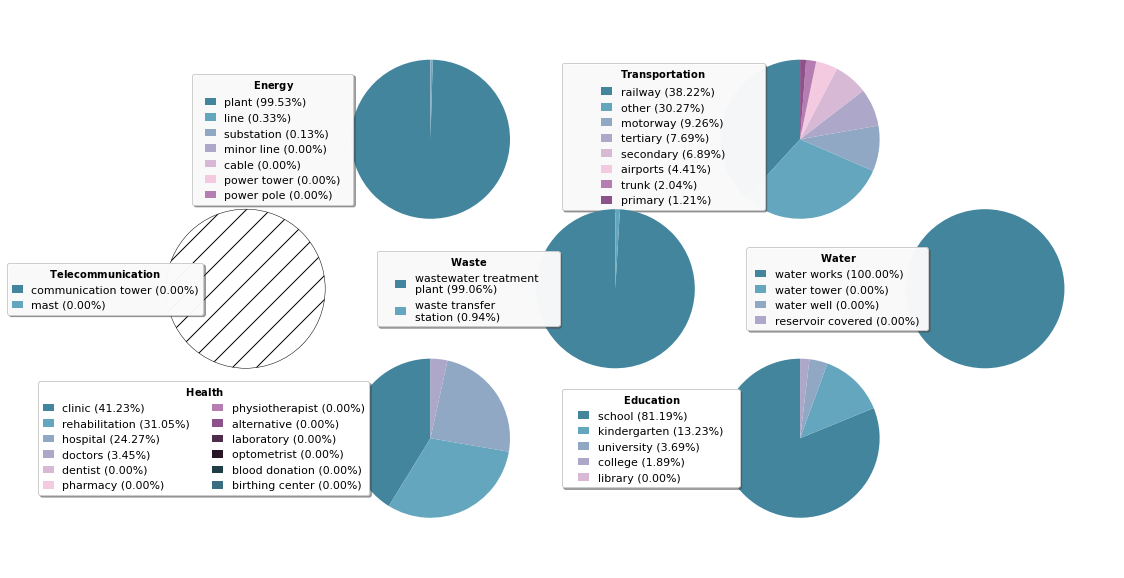

In [29]:
#import excel file
storm =  'Xaver' #'EmiliaRomagna' ''Xynthia'#
damage_df = pd.read_csv(os.path.join(damage_data_path, 'total_damage_{}.csv'.format(storm)))

#organize data per system 
infra_per_system_dict = get_list_per_system(assets) #get list per system
damage_dict = {}
for system in system_lst:
    lst_zeros = [0.0] * len(infra_per_system_dict[system])
    subset_df = pd.DataFrame({'infrastructure_type':infra_per_system_dict[system]})
    subset_df.insert(1, 'damage', lst_zeros)
    subset_df = subset_df.set_index('infrastructure_type')

    for asset in infra_per_system_dict[system]:
        if True in (damage_df['asset']==asset).unique():
            subset_df.loc[asset, 'damage'] += (damage_df[damage_df['asset']==asset])['damage'].sum()
            #print(subset_df)
    damage_dict['{}'.format(system)] = subset_df
    
#adjust damage_dict 
airport_components = ['runway','terminal']
damage_dict['transportation'].loc['airports'].damage = 0 
for component in airport_components: #Recalculate airport damage by calculating the total damage to terminals and runways.
    damage_dict['transportation'].loc['airports'].damage += damage_dict['transportation'].loc[component].damage 
    damage_dict['transportation'] = damage_dict['transportation'].drop([component]) #drop airport damage.  

fig4 = plt.figure(constrained_layout=False, figsize=(18, 18))
gs = fig4.add_gridspec(3, 6, height_ratios=[1,1,1],width_ratios=[1,1,1,1,1,1])

f4_ax1 = fig4.add_subplot(gs[0, 1:3])
f4_ax2 = fig4.add_subplot(gs[0, 3:5])
f4_ax3 = fig4.add_subplot(gs[1, 0:2])
f4_ax4 = fig4.add_subplot(gs[1, 2:4])
f4_ax5 = fig4.add_subplot(gs[1, 4:6])
f4_ax6 = fig4.add_subplot(gs[2, 1:3])
f4_ax7 = fig4.add_subplot(gs[2, 3:5])

colors = ['#43859D', '#64a6bd', '#90a8c3', '#ada7c9', '#d7b9d5', '#f4cae0','#B57DB1', '#8E528A','#4E2D4C', '#271626','#1F3D47','#386E80']
                       
#plot 1
data = organize_columns(damage_dict['energy'])
x,y,relative = data[0], data[1], data[2] 

patches, texts = f4_ax1.pie(y, colors=colors, startangle=90, radius=0.75)
labels = ['{0} ({1:1.2f}%)'.format(i.replace('_',' '),j) for i,j in zip(x, relative)] 

f4_ax1.legend(patches, labels, loc='center left', bbox_to_anchor=(-0.42, 0.5),
           fontsize=11, title='{: ^48}'.format(r"$\bfEnergy}$"), handlelength=1, shadow=True, facecolor="white", framealpha=0.95)

#plot 2
data = organize_columns(damage_dict['transportation'])
x,y,relative = data[0], data[1], data[2] 

patches, texts = f4_ax2.pie(y, colors=colors, startangle=90, radius=0.75)
labels = ['{0} ({1:1.2f}%)'.format(i.replace('_',' '),j) for i,j in zip(x, relative)] 

f4_ax2.legend(patches, labels, loc='center left', bbox_to_anchor=(-0.42, 0.51),
           fontsize=11, title='{: ^55}'.format(r"$\bfTransportation}$"), handlelength=1, shadow=True, facecolor="white", framealpha=0.95)

#plot 3
#import excel file
data = organize_columns(damage_dict['telecommunication'])
x,y,relative = data[0], data[1], data[2] 

patches, texts = f4_ax3.pie(y, colors=colors, startangle=90, radius=0.75)
labels = ['{0} ({1:1.2f}%)'.format(i.replace('_',' '),j) for i,j in zip(x, relative)] 
labels[1] = labels[1].replace('communication tower', 'communication\ntower')


patches_fake, text_fake= f4_ax3.pie(100, colors='white', startangle=90, radius=0.75, wedgeprops={'alpha':1, "edgecolor":"k",'linewidth': 0.5, 'linestyle': 'solid'}) #create empty circle with edge color
patches_fake[0].set_hatch('/')

f4_ax3.legend(patches, labels, loc='center left', bbox_to_anchor=(-0.42, 0.5),
           fontsize=11, title='{: ^42}'.format(r"$\bfTelecommunication}$"), handlelength=1, shadow=True, facecolor="white", framealpha=0.95)

#plot 4
#import excel file
data = organize_columns(damage_dict['waste'])
x,y,relative = data[0], data[1], data[2] 

patches, texts = f4_ax4.pie(y, colors=colors, startangle=90, radius=0.75)
labels = ['{0} ({1:1.2f}%)'.format(i.replace('_',' '),j) for i,j in zip(x, relative)] 
labels[0]= labels[0].replace('wastewater treatment plant', 'wastewater treatment \nplant')
labels[1] = labels[1].replace('waste transfer station', 'waste transfer\nstation')

#patches_fake, text_fake= f4_ax4.pie(100, colors='white', startangle=90, radius=0.75, wedgeprops={'alpha':1, "edgecolor":"k",'linewidth': 0.5, 'linestyle': 'solid'}) #create empty circle with edge color
#patches_fake[0].set_hatch('/')

f4_ax4.legend(patches, labels, loc='center left', bbox_to_anchor=(-0.42, 0.5),
           fontsize=11, title='{: ^55}'.format(r"$\bfWaste}$"), handlelength=1, shadow=True, facecolor="white", framealpha=0.95)

#plot 5
#import excel file
data = organize_columns(damage_dict['water'])
x,y,relative = data[0], data[1], data[2] 

patches, texts = f4_ax5.pie(y, colors=colors, startangle=90, radius=0.75)
labels = ['{0} ({1:1.2f}%)'.format(i.replace('_',' '),j) for i,j in zip(x, relative)] 

#patches_fake, text_fake= f4_ax5.pie(100, colors='white', startangle=90, radius=0.75, wedgeprops={'alpha':1, "edgecolor":"k",'linewidth': 0.5, 'linestyle': 'solid'}) #create empty circle with edge color
#patches_fake[0].set_hatch('/')

f4_ax5.legend(patches, labels, loc='center left', bbox_to_anchor=(-0.42, 0.5),
           fontsize=11, title='{: ^55}'.format(r"$\bfWater}$"), handlelength=1, shadow=True, facecolor="white", framealpha=0.95)

#plot 6
#import excel file
data = organize_columns(damage_dict['healthcare'])
x,y,relative = data[0], data[1], data[2] 

patches, texts = f4_ax6.pie(y, colors=colors, startangle=90, radius=0.75)
labels = ['{0} ({1:1.2f}%)'.format(i.replace('_',' '),j) for i,j in zip(x, relative)] 

f4_ax6.legend(patches, labels, loc='center left', bbox_to_anchor=(-1, 0.5),
           fontsize=11, title='{: ^55}'.format(r"$\bf{Health}$"), handlelength=1, shadow=True, ncol=2) 

#plot 7
#import excel file
data = organize_columns(damage_dict['education'])
x,y,relative = data[0], data[1], data[2] 

patches, texts = f4_ax7.pie(y, colors=colors, startangle=90, radius=0.75)
labels = ['{0} ({1:1.2f}%)'.format(i.replace('_',' '),j) for i,j in zip(x, relative)] 

f4_ax7.legend(patches, labels, loc='center left', bbox_to_anchor=(-0.42, 0.5),
           fontsize=11, title='{: ^52}'.format(r"$\bf{Education}$"), handlelength=1, shadow=True)


#gs.update(hspace=0.05) #wspace=0.025, hspace=0.05)
plt.subplots_adjust(hspace=-0.78, wspace=1.3)#, hspace=0)

plt.show()

fig4.savefig(os.path.join(output_path, 'Fig_circle_{}.png'.format(storm)), bbox_inches='tight', dpi=1000)

In [77]:
damage_dict['energy'].damage.sum() + damage_dict['transportation'].damage.sum() + damage_dict['telecommunication'].damage.sum() + damage_dict['waste'].damage.sum() + damage_dict['water'].damage.sum() + damage_dict['healthcare'].damage.sum() + damage_dict['education'].damage.sum()

13110907.262204487

In [58]:
damage_dict['transportation'].sum()

damage    4.215049e+06
dtype: float64

In [56]:
# damage to roads
print(damage_dict['transportation'].loc['primary'] + damage_dict['transportation'].loc['secondary']  + damage_dict['transportation'].loc['tertiary']  + damage_dict['transportation'].loc['other']  + damage_dict['transportation'].loc['motorway']  + damage_dict['transportation'].loc['trunk'] )

damage    2.418145e+06
dtype: float64


In [57]:
damage_dict['transportation'].loc['railway']

damage    1.610867e+06
Name: railway, dtype: float64

In [62]:
damage_dict['transportation'].loc['airports']

damage    186036.613081
Name: airports, dtype: float64

In [58]:
damage_dict['healthcare'].sum() - damage_dict['healthcare'].loc['hospital']

damage    878554.192596
dtype: float64

In [151]:
5.798244e+09

5798244000.0

In [152]:
3.766771e+08

376677100.0

In [154]:
8.515173e+06/658.47

12931.75543304934

In [11]:
infra_path_temp = os.path.abspath(r"\\labsdfs.labs.vu.nl\labsdfs\BETA-IVM-BAZIS\data_catalogue\open_street_map\receipt_storylines\osm_data")
df = from_geofeather(os.path.join(infra_path_temp, '{}_education_facilities.feather'.format('ITA')))

In [39]:
type(df['geometry'].loc[0])

pygeos.lib.GEOSGeometry

In [12]:
df['geometry']

0        POLYGON ((12.6 35.5, 12.6 35.5, 12.6 35.5, 12....
1        POLYGON ((12.6 35.5, 12.6 35.5, 12.6 35.5, 12....
2        POLYGON ((12.6 35.5, 12.6 35.5, 12.6 35.5, 12....
3        POLYGON ((12.6 35.5, 12.6 35.5, 12.6 35.5, 12....
4        POLYGON ((15.1 36.7, 15.1 36.7, 15.1 36.7, 15....
                               ...                        
21117    POLYGON ((11.6 47, 11.6 47, 11.6 47, 11.6 47, ...
21118    POLYGON ((11.9 47, 11.9 47, 11.9 47, 11.9 47, ...
21119    POLYGON ((11.9 47, 11.9 47, 11.9 47, 11.9 47, ...
21120    POLYGON ((12 47, 12 47, 12 47, 12 47, 12 47, 1...
21121        POLYGON ((12 47, 12 47, 12 47, 12 47, 12 47))
Name: geometry, Length: 21122, dtype: object

## exposed assets

In [64]:
damage_data_path_temp = os.path.abspath(r"\\labsdfs.labs.vu.nl\labsdfs\BETA-IVM-BAZIS\data_catalogue\open_street_map\receipt_storylines\damage_data")
df = pd.read_csv(os.path.join(damage_data_path_temp, 'education_facilities_{}.csv'.format('ITA')))
df = df.drop(columns='Unnamed: 0')

In [66]:
from shapely.wkb import loads
temp_df = df.copy()
temp_df['geometry'] = pygeos.from_wkt(temp_df.geometry) 
temp_df['geometry'] = temp_df.geometry.apply(lambda x : loads(pygeos.to_wkb(x))) #transform geometry back to shapely geometry
temp_df = gpd.GeoDataFrame(temp_df, crs="EPSG:5659", geometry='geometry')
temp_df.to_file(os.path.join(os.path.abspath(r'C:\Users\snn490\surfdrive\PhD documents\RECEIPT project\Deliverables\Deliverable 2021\damage_data'), 'education_facilities_{}.gpkg'.format('ITA')), layer=' ',driver="GPKG")

# spatial figures

In [17]:
damage_data_path_temp = os.path.abspath(r"\\labsdfs.labs.vu.nl\labsdfs\BETA-IVM-BAZIS\data_catalogue\open_street_map\receipt_storylines\damage_data") #path to damage data
grid_data_path = os.path.abspath(r"\\labsdfs.labs.vu.nl\labsdfs\BETA-IVM-BAZIS\data_catalogue\open_street_map\receipt_storylines\gridded_data")#path to grid data

assets = {"energy": {"power": ["line", "minor_line","cable","plant","substation",
                                        "power_tower","power_pole"]}, 
                "transportation": {"roads":  ["motorway","trunk","primary", "secondary", "tertiary","other"], 
                                    "airports": ["airports", "runway", "terminal"],
                                    "railways": ["railway"]},
                "water": {"water_supply": ["water_tower", "water_well", "reservoir_covered",
                                            "water_works"]},
                "waste": {"waste_solid": ["waste_transfer_station"],
                        "waste_water": ["wastewater_treatment_plant"]},
                "telecommunication": {"telecom": ["communication_tower", "mast"]},
                "healthcare": {"health": ["clinic", "doctors", "hospital", "dentist", "pharmacy", 
                            "physiotherapist", "alternative", "laboratory", "optometrist", "rehabilitation", 
                            "blood_donation", "birthing_center"]},
                "education": {"education_facilities": ["college", "kindergarten", "library", "school", "university"]}
                }

# create variables
system_lst = [system for system in assets] #make list with systems
#subsystem_lst = [subsystem for system in assets for subsystem in assets[system]] #make list with subsystems

#storm_dict = {'Xynthia': 'FRA'}#, 'Xaver': 'DEU', 'EmiliaRomagna': 'ITA'} 
storm_dict = {'Xaver': 'DEU'}#, 'EmiliaRomagna': 'ITA'}
#storm_dict = {'EmiliaRomagna': 'ITA'} 

In [18]:
damage_dict = {}
infra_per_system_dict = get_list_per_system(assets) #get list per system
datatypes_dict = {'power':['lines','poly','point'],'airports':['lines','poly']} 

for storm in storm_dict:
    print(storm)
    
    #organize grid data for storm
    gridded_country= from_geofeather(os.path.join(grid_data_path, '{}_gridded_0.01.geofeather'.format(storm_dict[storm])))
    gridded_country = functions.transform_to_gpd(gridded_country)
    if storm in ['Xaver','Xynthia']:
        gridded_country = gridded_country.to_crs(epsg=3857)
    else: #for Italy
        gridded_country = gridded_country.to_crs(epsg=5659)
    
    gridded_country = pd.DataFrame(gridded_country) 
    gridded_country['geometry'] = pygeos.from_shapely(gridded_country.geometry) #back to pygeos
    #add damage column
    gridded_country["damage"] = 0.0
    
    #organize damage data per asset per sub_system 
    for system in system_lst:
        for sub_system in assets[system]:
            subset_df = pd.DataFrame(columns = ['asset','damage','geometry'])
            if sub_system == 'power':
                for datatype in datatypes_dict['power']:
                    temp_df = gpd.read_file(os.path.join(damage_data_path, '{}_{}_{}.shp'.format(storm_dict[storm], sub_system, datatype)))
                    temp_df = temp_df[['asset','damage','geometry']]
                    subset_df = subset_df.append(temp_df)
                subset_df = subset_df.reset_index(drop=True)
                damage_dict['{}'.format(sub_system)] = subset_df  
            
            elif sub_system == 'airports':
                for datatype in datatypes_dict['airports']:
                    temp_df = gpd.read_file(os.path.join(damage_data_path, '{}_{}_{}.shp'.format(storm_dict[storm], sub_system, datatype)))
                    temp_df = temp_df[['asset','damage','geometry']]
                    subset_df = subset_df.append(temp_df)
                subset_df = subset_df.reset_index(drop=True)
                damage_dict['{}'.format(sub_system)] = subset_df  
                print(subset_df)
                    
            else:
                if os.path.isfile(os.path.join(damage_data_path, '{}_{}.shp'.format(storm_dict[storm], sub_system))):
                    temp_df = gpd.read_file(os.path.join(damage_data_path, '{}_{}.shp'.format(storm_dict[storm], sub_system)))
                    temp_df = temp_df[['asset','damage','geometry']]
                subset_df = temp_df.reset_index(drop=True)
                damage_dict['{}'.format(sub_system)] = subset_df 
                    
    ##calculate damage per grid cell
    for system in assets:
        print(system)
        for sub_system in assets[system]:
            print('This is {}'.format(sub_system))
            #delete exposed assets without damage
            damage_df = (damage_dict[sub_system][damage_dict[sub_system]['damage']!=0.0]).reset_index(drop=True) #drop damages = 0
            for asset in assets[system][sub_system]:
                if asset != 'airports': #exclude airports
                    if True in (damage_df['asset']==asset).unique():
                        asset_damage_df = (damage_df[damage_df['asset']==asset])
                        asset_damage_df = pd.DataFrame(asset_damage_df) 
                        asset_damage_df['geometry'] = pygeos.from_shapely(asset_damage_df.geometry) 
                        if asset_damage_df.empty == False:
                            geometry_type = pygeos.geometry.get_type_id(asset_damage_df.iloc[0]["geometry"]) #get geometry id
                            #check for each asset if overlap with grid cell
                            spat_tree = pygeos.STRtree(gridded_country.geometry) # https://pygeos.readthedocs.io/en/latest/strtree.htm
                            for asset_row in asset_damage_df.itertuples():
                                grid_overlay_df = (gridded_country.loc[spat_tree.query(asset_row.geometry,predicate='intersects').tolist()]).sort_index(ascending=True) #get assets that overlaps with polygon
                                if len(grid_overlay_df) == 1:
                                    gridded_country.loc[grid_overlay_df.index, 'damage'] += asset_row.damage #assign damage to grid cell
                                elif len(grid_overlay_df) > 1: 
                                    for grid_row in grid_overlay_df.itertuples():
                                        gridded_country.loc[grid_row.Index, 'damage'] += asset_row.damage/len(grid_overlay_df) #assign disaggregated damage to grid cell
    
    gridded_country_set = gridded_country[gridded_country['damage'] != 0.0]   #remove all grid cells with nan/0 data
    gridded_country_set = gridded_country_set.reset_index(drop=True)
    
    # save as geofeather and gpkg
    from shapely.wkb import loads
    if storm in ['Xaver','Xynthia']:
        #to_geofeather(gridded_country_set, os.path.join(os.path.abspath(r'\\labsdfs.labs.vu.nl\labsdfs\BETA-IVM-BAZIS\data_catalogue\open_street_map\receipt_storylines\gridded_data\damage'), '{}_gridded_0_01.geofeather'.format(storm_dict[storm])), crs="EPSG=3857") #save as geofeather

        temp_df = gridded_country_set.copy()
        temp_df['geometry'] = temp_df.geometry.apply(lambda x : loads(pygeos.to_wkb(x))) #transform geometry back to shapely geometry
        temp_df = gpd.GeoDataFrame(temp_df, crs="EPSG:3857", geometry='geometry')
        with Geopackage(os.path.join(os.path.abspath(r'\\labsdfs.labs.vu.nl\labsdfs\BETA-IVM-BAZIS\data_catalogue\open_street_map\receipt_storylines\gridded_data\damage'),'{}_gridded_0_01.gpkg'.format(storm_dict[storm])), 'w') as out:   
            out.add_layer(gridded_country_set, name=' ')
    else: #for Italy
        to_geofeather(gridded_country_set, os.path.join(os.path.abspath(r'\\labsdfs.labs.vu.nl\labsdfs\BETA-IVM-BAZIS\data_catalogue\open_street_map\receipt_storylines\gridded_data\damage'), '{}_gridded_0_01.geofeather'.format(storm_dict[storm])), crs="EPSG=5659") #save as geofeather

        temp_df = gridded_country_set.copy()
        temp_df['geometry'] = temp_df.geometry.apply(lambda x : loads(pygeos.to_wkb(x))) #transform geometry back to shapely geometry
        temp_df = gpd.GeoDataFrame(temp_df, crs="EPSG:5659", geometry='geometry')
        with Geopackage(os.path.join(os.path.abspath(r'\\labsdfs.labs.vu.nl\labsdfs\BETA-IVM-BAZIS\data_catalogue\open_street_map\receipt_storylines\gridded_data\damage'),'{}_gridded_0_01.gpkg'.format(storm_dict[storm])), 'w') as out:   
            out.add_layer(gridded_country_set, name=' ')

        
                    

Xaver


KeyboardInterrupt: 

In [38]:
gridded_country_set

,geometry,damage
0,"POLYGON ((-5.25e+05 6.12e+06, -5.24e+05 6.12e+...",47.316573
1,"POLYGON ((-5.25e+05 6.12e+06, -5.24e+05 6.12e+...",1536.703357
2,"POLYGON ((-5.2e+05 6.12e+06, -5.19e+05 6.12e+0...",930.347820
3,"POLYGON ((-5.19e+05 6.11e+06, -5.18e+05 6.11e+...",128.518028
4,"POLYGON ((-5.16e+05 6.11e+06, -5.15e+05 6.11e+...",1039.026081
...,...,...
3391,"POLYGON ((-1.04e+04 5.59e+06, -9.32e+03 5.59e+...",338.025118
3392,"POLYGON ((-9.32e+03 5.59e+06, -8.21e+03 5.59e+...",230.712224
3393,"POLYGON ((-9.32e+03 5.59e+06, -8.21e+03 5.59e+...",107.312894
3394,"POLYGON ((5.15e+03 5.59e+06, 6.26e+03 5.59e+06...",87.112885


In [29]:
gridded_country_set = gridded_country[gridded_country['damage'] != 0.0]

In [15]:
grid_row.Index

372113

In [216]:
asset_row.damage/len(grid_overlay_df)

1

In [209]:
390425.22398361465 + 58723.71641297434

449148.940396589

In [206]:
gridded_country[gridded_country['damage'] != 0.0] 

,geometry,damage
390717,"POLYGON ((-1.3e+05 5.8e+06, -1.28e+05 5.8e+06,...",507872.65681


In [188]:
type(asset_row.damage)

float

In [137]:
              spat_tree = pygeos.STRtree(df_subset.geometry) # https://pygeos.readthedocs.io/en/latest/strtree.htm
                for aerodrome_row in df_adjust.itertuples():
                    df_overlapping_assets = (df_subset.loc[spat_tree.query(aerodrome_row.aerodrome_geometry,predicate='intersects').tolist()]).sort_index(ascending=True) #get assets that overlaps with polygon
                    #calculate amount of infrastructure associated to infrastructure type that falls within aeredrome
                    df_overlapping_assets.insert(1, "amount", "") #add assettype as column after first column for length calculations
                    if not df_overlapping_assets.empty:

geopandas.geodataframe.GeoDataFrame